In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
IMG_HELP_PATH = '/Users/shankar/dev/code/ds/studies/data_science/dlcv'
import os
import sys
sys.path.append(os.path.abspath(IMG_HELP_PATH))
from common.preprocessing import ImageToArrayPreprocessor
from common.preprocessing import AspectAwarePreprocessor
from common.datasets import SimpleDatasetLoader
from common.nn.conv import MiniVGGNet

In [3]:
DATASET = '../datasets/flowers17/images'

In [4]:
print("[INFO] Loading images")
imagePaths = list(paths.list_images(DATASET))
classNames = [ pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

[INFO] Loading images


In [5]:
aap = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()

In [6]:
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float")/255.0

[INFO] processed 500/1360
[INFO] processed 1000/1360


In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.25, random_state=42)

In [8]:
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

In [9]:
aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
print("[INFO] Compiling model")
opt = SGD(lr=0.05)
model = MiniVGGNet.build(width=64, height=64, depth=3, classes=len(classNames))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

[INFO] Compiling model


In [11]:
print("[INFO] Training Network")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=32),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX)//32,
    epochs=100,
    verbose=1          
)

[INFO] Training Network
Epoch 1/100
31/31 [==============================] - 22s 724ms/step - loss: 3.4530 - acc: 0.1829 - val_loss: 3.5023 - val_acc: 0.2412
Epoch 2/100
31/31 [==============================] - 22s 708ms/step - loss: 2.5351 - acc: 0.2951 - val_loss: 2.5256 - val_acc: 0.3706
Epoch 3/100
31/31 [==============================] - 22s 710ms/step - loss: 2.2560 - acc: 0.3698 - val_loss: 2.0499 - val_acc: 0.4206
Epoch 4/100
31/31 [==============================] - 22s 705ms/step - loss: 2.0437 - acc: 0.3908 - val_loss: 1.9428 - val_acc: 0.4559
Epoch 5/100
31/31 [==============================] - 22s 707ms/step - loss: 1.9941 - acc: 0.4244 - val_loss: 1.8326 - val_acc: 0.5088
Epoch 6/100
31/31 [==============================] - 22s 711ms/step - loss: 1.7273 - acc: 0.4929 - val_loss: 1.6316 - val_acc: 0.5206
Epoch 7/100
31/31 [==============================] - 22s 706ms/step - loss: 1.6191 - acc: 0.4929 - val_loss: 1.8498 - val_acc: 0.5000
Epoch 8/100
31/31 [===================

In [12]:
print("[INFO] evaluating network")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=classNames))


[INFO] evaluating network
             precision    recall  f1-score   support

   bluebell       0.73      1.00      0.84        16
  buttercup       0.76      0.87      0.81        15
  coltsfoot       0.61      0.70      0.65        20
    cowslip       0.82      0.50      0.62        18
     crocus       0.64      0.80      0.71        20
   daffodil       0.57      0.35      0.43        23
      daisy       0.90      0.95      0.92        19
  dandelion       0.71      0.67      0.69        18
 fritillary       0.84      0.84      0.84        19
       iris       0.94      0.81      0.87        21
 lilyvalley       0.75      0.75      0.75        20
      pansy       0.95      0.78      0.86        27
   snowdrop       0.62      0.73      0.67        22
  sunflower       0.85      0.96      0.90        23
  tigerlily       0.94      0.94      0.94        16
      tulip       0.44      0.55      0.49        20
 windflower       0.95      0.78      0.86        23

avg / total       

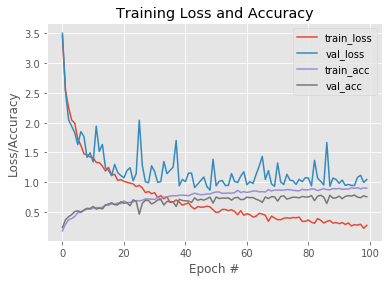

In [13]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()